In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

In [50]:
path=Path('data/Candle Sticks/CandleData')
path_save=Path('data/Candle Sticks/Processed')

In [6]:
path.ls()

[PosixPath('data/Candle Sticks/CandleData/Up'),
 PosixPath('data/Candle Sticks/CandleData/Down'),
 PosixPath('data/Candle Sticks/CandleData/models'),
 PosixPath('data/Candle Sticks/CandleData/.ipynb_checkpoints')]

In [7]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0.,max_rotate=3), size=224, num_workers=4).normalize(imagenet_stats)

In [10]:
data.classes

['Down', 'Up']

<h1> Training the Model </h1>

In [11]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [12]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.293409,1.333741,0.484663,00:18
1,1.215402,0.888560,0.476483,00:17
2,1.016288,0.763593,0.480573,00:16
3,0.887842,0.744518,0.484663,00:17


In [13]:
learn.unfreeze()

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


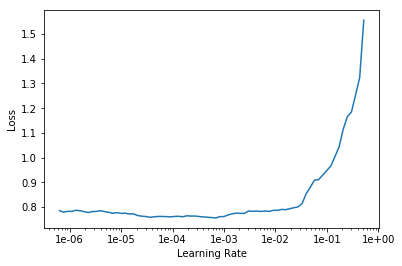

In [15]:
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.752549,0.744013,0.486708,00:16
1,0.734988,0.739380,0.464213,00:17
2,0.736778,0.724887,0.458078,00:17
3,0.730948,0.723458,0.474438,00:16
4,0.719952,0.714411,0.458078,00:16
5,0.712202,0.704705,0.464213,00:16
6,0.695633,0.706335,0.466258,00:16
7,0.691850,0.703327,0.464213,00:17
8,0.676340,0.703003,0.476483,00:17
9,0.675964,0.701894,0.464213,00:17


In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


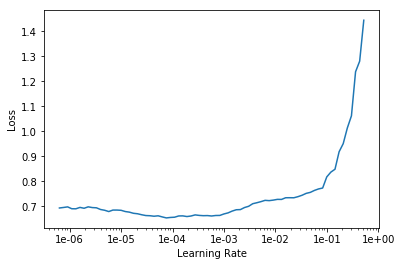

In [18]:
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.676047,0.697034,0.456033,00:17
1,0.678649,0.689777,0.433538,00:16
2,0.667470,0.689013,0.439673,00:16
3,0.650513,0.691708,0.439673,00:17
4,0.649764,0.689810,0.445808,00:16


In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


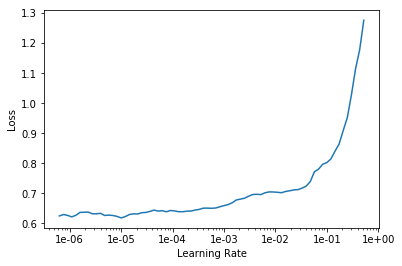

In [21]:
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(5,max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.632485,0.677004,0.427403,00:16
1,0.630447,0.667037,0.398773,00:17
2,0.613334,0.678722,0.378323,00:16
3,0.592594,0.671992,0.388548,00:16
4,0.583138,0.667380,0.376278,00:16


In [23]:
learn.save('First Model')

In [24]:
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0.,max_rotate=3), size=352, num_workers=4).normalize(imagenet_stats)

In [25]:
learn.data=data

In [26]:
gc.collect()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


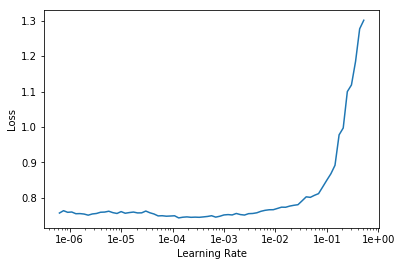

In [27]:
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(5,max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.774475,0.703659,0.425358,00:21
1,0.750636,0.672796,0.396728,00:21
2,0.720549,0.660479,0.388548,00:21
3,0.694842,0.667638,0.384458,00:21
4,0.663204,0.665604,0.382413,00:21


In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


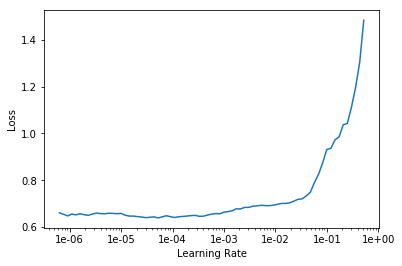

In [30]:
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(5,max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.640654,0.662567,0.382413,00:21
1,0.633229,0.662397,0.384458,00:21
2,0.627317,0.656364,0.394683,00:21
3,0.626663,0.655229,0.386503,00:21
4,0.626051,0.654990,0.384458,00:21


In [33]:
learn.save('Model 2')

In [34]:
correcti=0
list_down=[]
list_up=[]
for i in range(len(data.valid_ds)):
    prediction=learn.predict(data.valid_ds[i][0])
    if str(data.valid_ds[i][1])=="Down" and bool(prediction[1]==0) :
        correcti=correcti+1
        if prediction[2][0] >= 0.75 :
            list_down=list_down + [i]
            #print(prediction)
            #print()
    if str(data.valid_ds[i][1])=="Up" and bool(prediction[1]==1) :
        correcti=correcti+1
        if prediction[2][1] >= 0.75 :
            list_up=list_up + [i]
            #print(prediction)
            #print()
        

In [35]:
len(list_down),len(list_up)

(29, 45)

<h1> Finding the patterns </h1>

Up


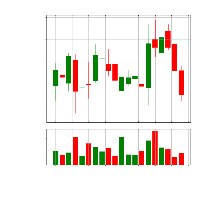

In [36]:
idx=233
x,y = data.valid_ds[idx]
x.show()
print(data.valid_ds.y[idx])

In [37]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [38]:
m = learn.model.eval()

In [39]:
from fastai.callbacks.hooks import *

In [40]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [41]:
hook_a,hook_g = hooked_backward()

In [42]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

In [43]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

In [46]:
def show_heatmap(hm):
    fig,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');
    return fig

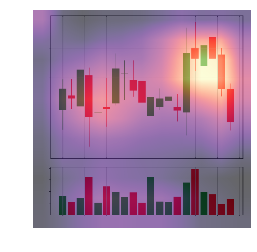

In [49]:
answer=show_heatmap(avg_acts)
answer.savefig(path/'trial.png')

In [98]:
list_up

[0,
 1,
 5,
 11,
 13,
 15,
 18,
 20,
 30,
 31,
 37,
 39,
 48,
 51,
 63,
 64,
 72,
 76,
 77,
 87,
 92,
 105,
 113,
 118,
 144,
 149,
 161,
 170,
 187,
 197,
 207,
 208,
 211,
 221,
 233,
 234,
 245,
 263,
 269,
 283,
 292,
 315,
 319,
 328,
 335,
 338,
 351,
 359,
 368,
 387,
 399,
 402,
 407,
 409,
 416,
 421,
 437,
 450,
 455,
 467,
 472,
 481]

Up
torch.Size([512, 11, 11])
torch.Size([11, 11])
11
Up
torch.Size([512, 11, 11])
torch.Size([11, 11])
13
Up
torch.Size([512, 11, 11])
torch.Size([11, 11])
20
Up
torch.Size([512, 11, 11])
torch.Size([11, 11])
30
Up
torch.Size([512, 11, 11])
torch.Size([11, 11])
51
Up
torch.Size([512, 11, 11])
torch.Size([11, 11])
60
Up
torch.Size([512, 11, 11])
torch.Size([11, 11])
72
Up
torch.Size([512, 11, 11])
torch.Size([11, 11])
77
Up
torch.Size([512, 11, 11])
torch.Size([11, 11])
87
Up
torch.Size([512, 11, 11])
torch.Size([11, 11])
92
Up


/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


torch.Size([512, 11, 11])
torch.Size([11, 11])
131
Up
torch.Size([512, 11, 11])
torch.Size([11, 11])
146
Up
torch.Size([512, 11, 11])
torch.Size([11, 11])
149
Up
torch.Size([512, 11, 11])


/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


torch.Size([11, 11])
161
Up
torch.Size([512, 11, 11])
torch.Size([11, 11])


/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


195
Up
torch.Size([512, 11, 11])
torch.Size([11, 11])
197
Up


/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


torch.Size([512, 11, 11])
torch.Size([11, 11])
208
Up
torch.Size([512, 11, 11])
torch.Size([11, 11])
211
Up
torch.Size([512, 11, 11])
torch.Size([11, 11])
220
Up


/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


torch.Size([512, 11, 11])
torch.Size([11, 11])
221
Up
torch.Size([512, 11, 11])
torch.Size([11, 11])


/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


229
Up
torch.Size([512, 11, 11])
torch.Size([11, 11])
233


/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Up
torch.Size([512, 11, 11])
torch.Size([11, 11])
234
Up
torch.Size([512, 11, 11])
torch.Size([11, 11])
245
Up
torch.Size([512, 11, 11])
torch.Size([11, 11])
263
Up


/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


torch.Size([512, 11, 11])
torch.Size([11, 11])
282
Up
torch.Size([512, 11, 11])
torch.Size([11, 11])


/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


298
Up
torch.Size([512, 11, 11])
torch.Size([11, 11])
309
Up


/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


torch.Size([512, 11, 11])
torch.Size([11, 11])
319
Up
torch.Size([512, 11, 11])
torch.Size([11, 11])
335
Up
torch.Size([512, 11, 11])
torch.Size([11, 11])
351
Up


/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


torch.Size([512, 11, 11])
torch.Size([11, 11])
355
Up
torch.Size([512, 11, 11])
torch.Size([11, 11])


/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


368
Up
torch.Size([512, 11, 11])
torch.Size([11, 11])
370
Up


/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


torch.Size([512, 11, 11])
torch.Size([11, 11])
378
Up
torch.Size([512, 11, 11])
torch.Size([11, 11])
387
Up
torch.Size([512, 11, 11])
torch.Size([11, 11])
399
Up

/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



torch.Size([512, 11, 11])
torch.Size([11, 11])
409
Up
torch.Size([512, 11, 11])
torch.Size([11, 11])


/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


416
Up
torch.Size([512, 11, 11])
torch.Size([11, 11])
437
Up
torch.Size([512, 11, 11])
torch.Size([11, 11])


/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


450
Up
torch.Size([512, 11, 11])
torch.Size([11, 11])
455
Up


/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


torch.Size([512, 11, 11])
torch.Size([11, 11])
467
Up
torch.Size([512, 11, 11])
torch.Size([11, 11])
472
Up
torch.Size([512, 11, 11])
torch.Size([11, 11])
481


/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


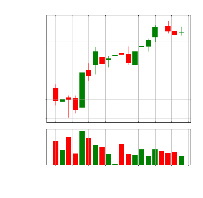

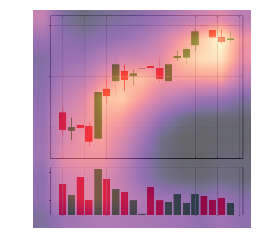

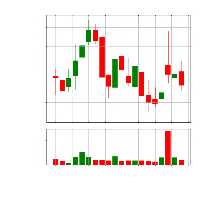

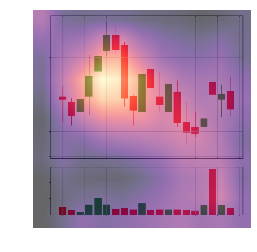

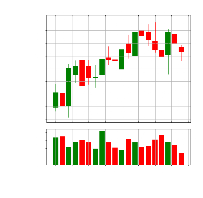

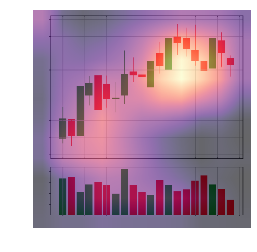

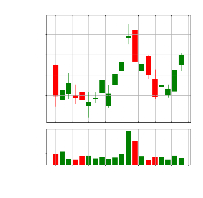

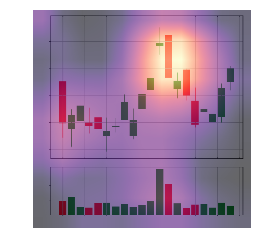

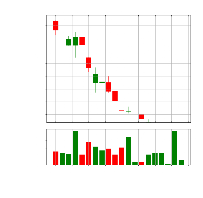

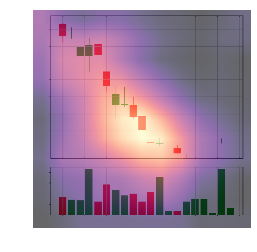

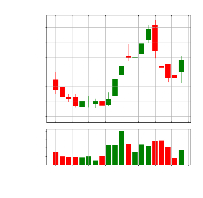

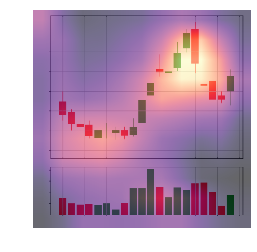

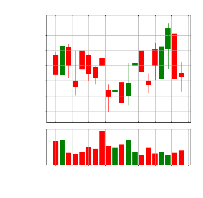

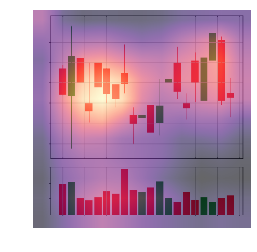

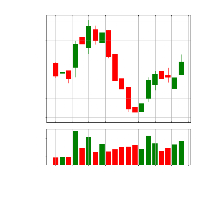

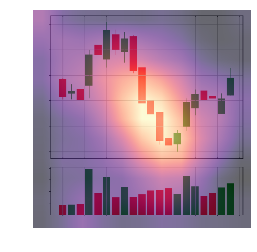

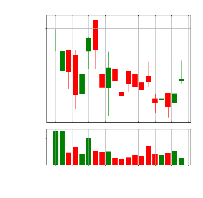

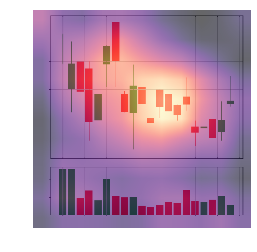

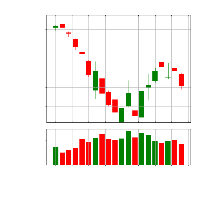

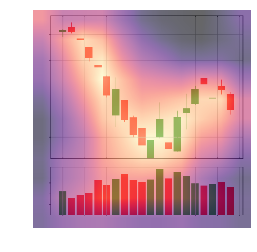

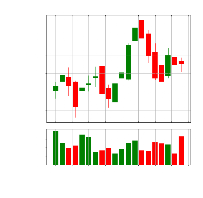

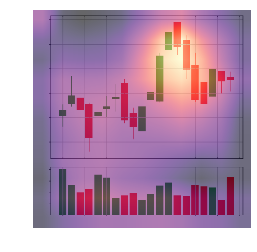

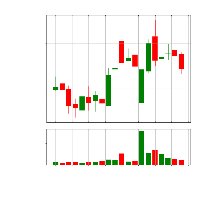

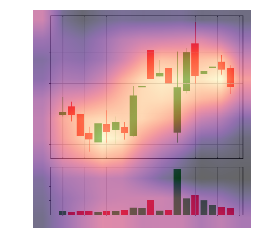

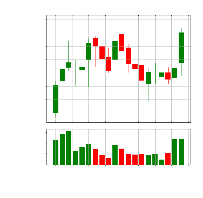

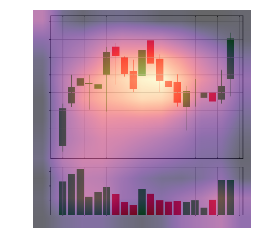

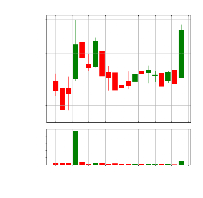

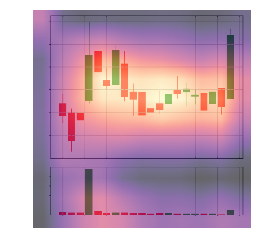

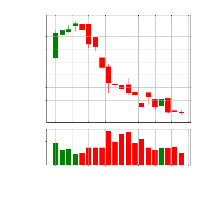

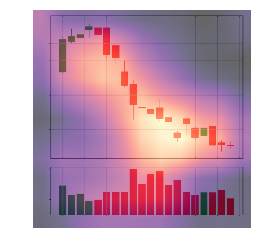

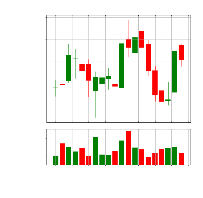

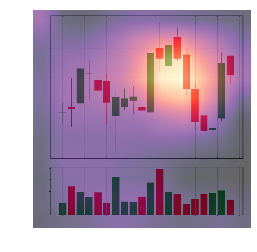

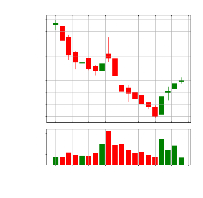

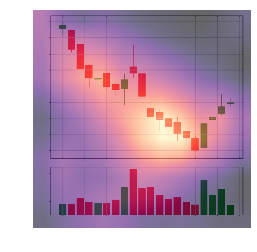

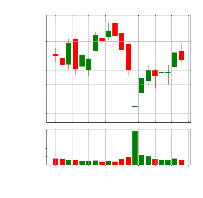

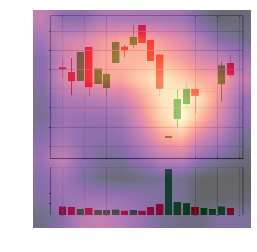

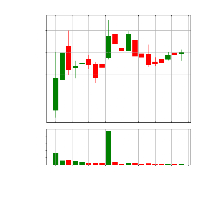

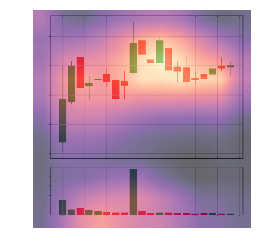

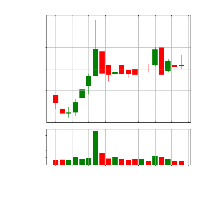

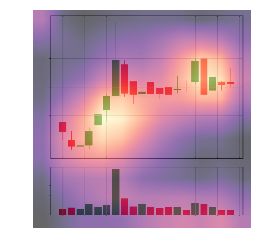

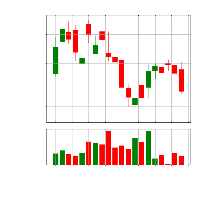

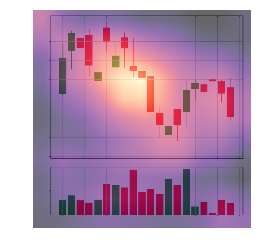

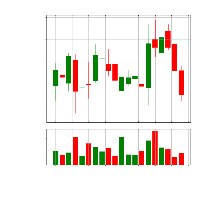

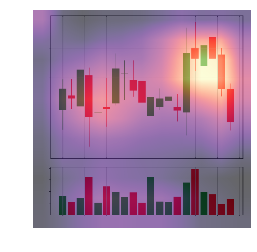

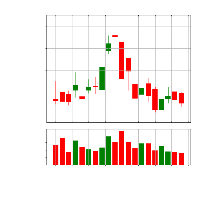

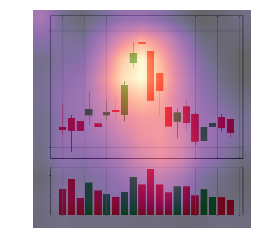

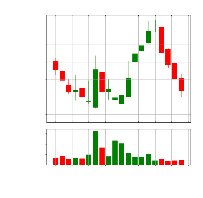

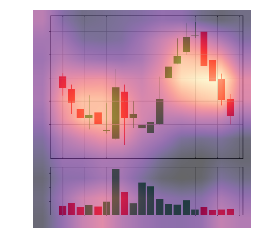

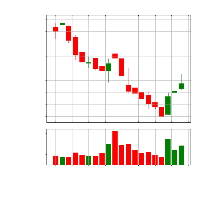

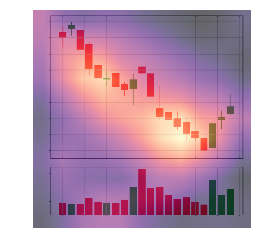

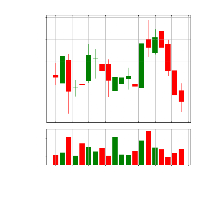

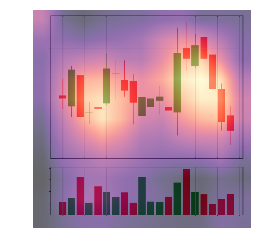

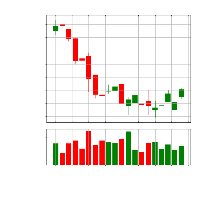

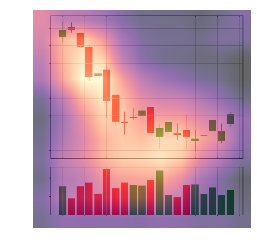

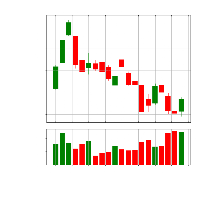

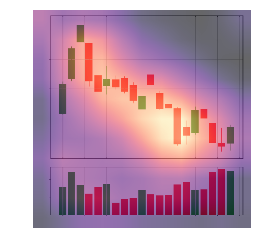

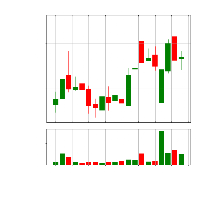

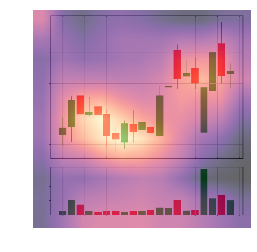

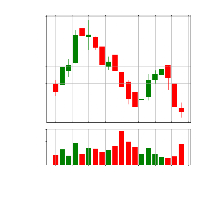

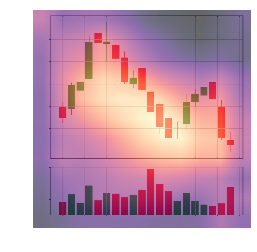

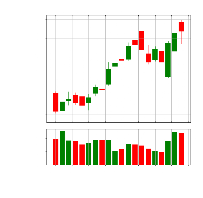

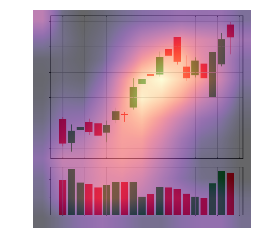

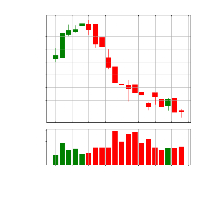

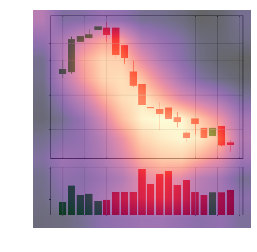

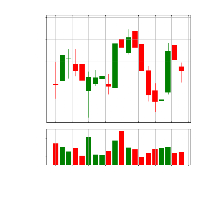

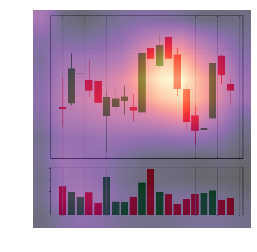

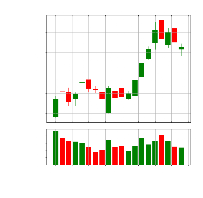

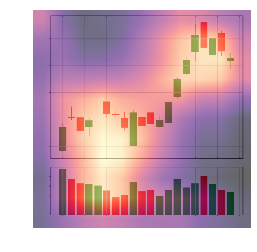

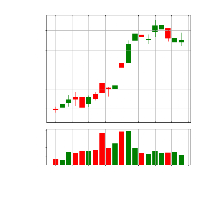

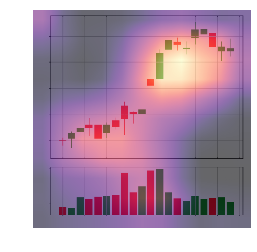

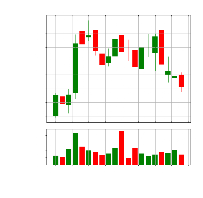

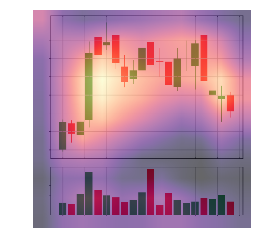

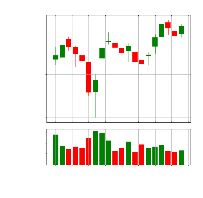

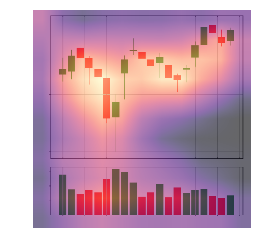

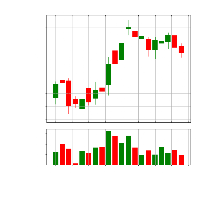

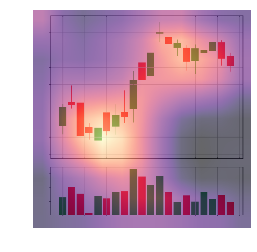

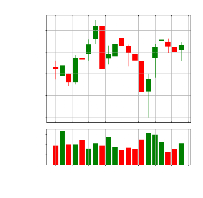

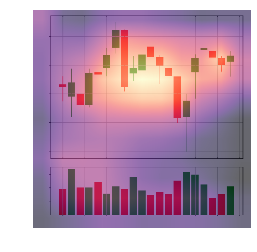

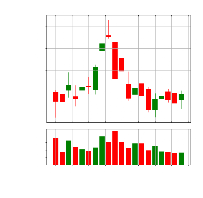

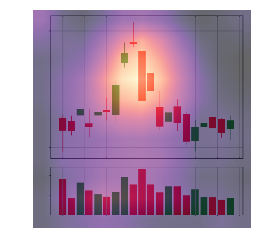

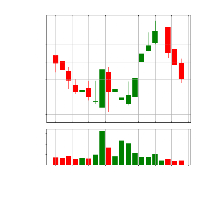

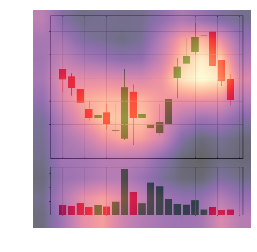

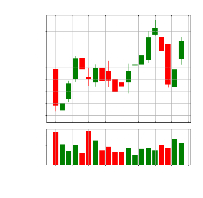

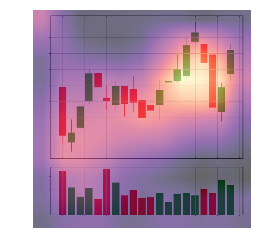

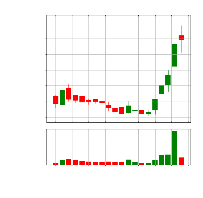

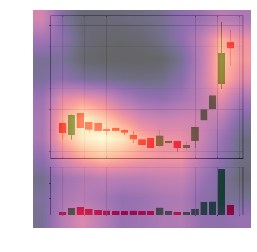

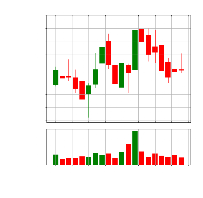

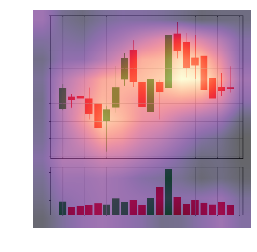

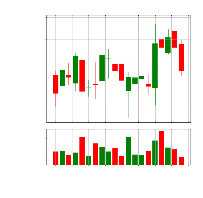

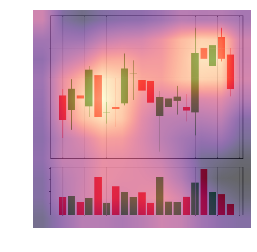

In [56]:
for idx in list_up :    
    x,y = data.valid_ds[idx]
    x.show()
    print(data.valid_ds.y[idx])
    xb,_ = data.one_item(x)
    xb_im = Image(data.denorm(xb)[0])
    xb = xb.cuda()
    m = learn.model.eval()
    hook_a,hook_g = hooked_backward()
    acts  = hook_a.stored[0].cpu()
    print(acts.shape)
    avg_acts = acts.mean(0)
    print(avg_acts.shape)
    answer=show_heatmap(avg_acts)
    answer.savefig(path_save/'Up/{0}.png'.format(idx))
    print(idx)